# World Series Baseball Predictor
Amazing bookmarked and forked git repo sources.

Key is make features, with a key feature being the Elo Score. The Random Forest is a natural sampler. Also try Logistic Regression. Train it on each world series bracket. Then predict some. Many more data points then if you use the whole bracket vs. just world series winner vs. not. Higher dimensional data, much more info now. 

Otherwise, one of the posts had the bright idea to Monte Carlo the outcomes and take the mode of the WS winner root node to see whose most likely to win. Or something like that. The Monte Carlo could be very powerful, to simulate the models over and over again, calculating probabilities at each step of the way for each realization. 

Need to see precisely how Elo works to determine if Monte Carlo is the best route - are win probabilities on an absolute scale or do they always depend on the opponent? Likely the latter. Two teams ranked 95%, when playing each other, will win only 50% of the time. 

### Elo
Probably best to initialize all teams to the same value. 162 games it should be plenty to distinguish the teams. You should make a **separate** script for calculating the elo scores for all teams for all years (since we have the data the rankings should be fixed), and then all you have to do is just load the elo scores.

### Retrosheet  
Data for elo = http://www.retrosheet.org/gamelogs/index.html  
Fields for data = http://www.retrosheet.org/gamelogs/glfields.txt  

## To do
Fit the right K_elo factors to real data? Do some machine learning for those. 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def calculate_elo_rank(winner_rank, loser_rank, k, penalize_loser=True):
    rank_diff = winner_rank - loser_rank
    exp = (rank_diff * -1)/400.
    odds = 1./(1 + pow(10, exp))
    new_winner_rank = round(winner_rank + (k * (1 - odds)))
    if penalize_loser:
        new_rank_diff = new_winner_rank - winner_rank
        new_loser_rank = loser_rank - new_rank_diff
    else:
        new_loser_rank = loser_rank
    if new_loser_rank < 1:
        new_loser_rank = 1
    return (new_winner_rank, new_loser_rank)

#from retrosheet
def get_gamelog(year):
    cols = ["Date","Team Away","Away Gm. No.","Team Home","Home Gm. No.","Team Away Score","Team Home Score"]
    GL = pd.read_csv("retrosheet_GL/GL"+str(year)+".TXT",usecols=[0,3,5,6,8,9,10],names=cols)
    awaywin = GL["Team Away Score"] > GL["Team Home Score"]
    homewin = -awaywin
    GL.loc[awaywin,"Winning Team"] = GL["Team Away"]
    GL.loc[awaywin,"Losing Team"] = GL["Team Home"]
    GL.loc[homewin,"Winning Team"] = GL["Team Home"]
    GL.loc[homewin,"Losing Team"] = GL["Team Away"]
    return GL

#Super fast with numpy arrays but dreadfully slow with Pandas DataFrames! 
def calc_season_elo(year,K_i,K_f):
    GL = get_gamelog(year)
    N = len(GL["Team Home"].unique())
    Team, Elo, wins = GL["Team Home"].unique().tolist(), 1500*np.ones(N), np.zeros(N)
    K_step = (K_f - K_i)/162.  #impact factor - games at end of season mean more for momentum and such
    
    for row in GL.itertuples():
        index_w = Team.index(row[8])
        index_l = Team.index(row[9])
        Elo[index_w], Elo[index_l] = calculate_elo_rank(Elo[index_w], Elo[index_l], K_i+row[3]*K_step)
        wins[index_w] += 1
    Data = zip(Team,Elo,wins)
    np.savetxt("retrosheet_GL/ELO"+str(year)+".TXT",Data,delimiter=",",fmt="%s")
    return Data

def get_season_elo(year,K_elo_i,K_elo_f):
    try:
        Data = np.genfromtxt("retrosheet_GL/ELO"+str(year)+".TXT",delimiter=",",dtype=None)
        return Data
    except:
        print "couldn't find Elo data for %d, calculating now."%year
        return calc_season_elo(year,K_elo_i,K_elo_f)

## Feature 1 - Monte Carlo the playoffs!
Now let's create the bracket and Monte Carlo the possible winners. Option to have Elo's during the playoffs as well as a linear gradient K factor to give more weight to later games in the season. Calculate "probability of winning WS" for each team as the number of times they win / number of attempts.

## To do - 
* need to set up the 1995-1997 brackets correctly. Gawd damnit.

In [9]:
def get_winner(team1, elo_1, team2, elo_2, series, K):
    P_1 = 1./(1 + pow(10,(elo_2 - elo_1) / 400.))
    if (series == "ALWC") | (series == "NLWC"):
        w_req = 1
    elif (series == "ALDS1") | (series == "ALDS2") | (series == "NLDS1") | (series == "NLDS2"):
        w_req = 3
    else:
        w_req = 4
    w_1 = 0
    w_2 = 0
    while (w_1 < w_req) & (w_2 < w_req):
        ran = np.random.uniform()
        if ran <= P_1:
            w_1 += 1
        else:
            w_2 += 1
    if w_1 == w_req:
        elo_1, elo_2 = calculate_elo_rank(elo_1, elo_2, K)
        return team1, elo_1
    else:
        elo_2, elo_1 = calculate_elo_rank(elo_2, elo_1, K)
        return team2, elo_2

def get_bracket(data,year,K_elo):  #1994 no WS, 1995-1997 is really weird seeding. Gonna be super annoying...
    Team, Elo, wins = zip(*data)
    teams = pd.read_csv("csv/team.csv")
    teams = teams.loc[(teams["year"]==year)] 
    
    AL = teams.loc[(teams["league_id"]=="AL")&(teams["rank"]==1)].sort_values("w")
    team_name = AL.loc[:,"team_id_retro"].values.tolist()
    team_div = AL.loc[:,"div_id"].values.tolist()
    team_elo = []
    for t in team_name:
        t_id = Team.index(t)
        team_elo.append(Elo[t_id])
    if year >= 1994:
        WCAL = teams.loc[(teams["rank"]>1)&(teams["league_id"]=="AL")].sort_values("w",ascending=False)
        if year >= 2012:
            WCALteams = WCAL.loc[:,"team_id_retro"].values[0:2]
            t1 = Team.index(WCALteams[0])
            t2 = Team.index(WCALteams[1])
            team_name.insert(0,Team[t1])
            team_elo.insert(0,Elo[t1])
            team_name.insert(0,Team[t2])
            team_elo.insert(0,Elo[t2])
        else:
            if WCAL.loc[:,"div_id"].values[0] == team_div[-1]: #stupid 1998-2011 WC rules
                team_name[-2], team_name[-1] = team_name[-1], team_name[-2]
                team_elo[-2], team_elo[-1] = team_elo[-1], team_elo[-2]
            t1 = Team.index(WCAL.loc[:,"team_id_retro"].values[0])
            team_name.append(Team[t1])
            team_elo.append(Elo[t1])

    NL = teams.loc[(teams["league_id"]=="NL")&(teams["rank"]==1)].sort_values("w")
    dummy = NL.loc[:,"team_id_retro"].values.tolist()
    team_div = NL.loc[:,"div_id"].values.tolist()
    for t in dummy:
        t_id = Team.index(t)
        team_name.append(t)
        team_elo.append(Elo[t_id])
    if year >= 1994:
        WCNL = teams.loc[(teams["rank"]>1)&(teams["league_id"]=="NL")].sort_values("w",ascending=False)
        if year >= 2012:
            WCNLteams = WCNL.loc[:,"team_id_retro"].values[0:2]
            t1 = Team.index(WCNLteams[0])
            t2 = Team.index(WCNLteams[1])
            team_name.insert(2,Team[t1])
            team_elo.insert(2,Elo[t1])
            team_name.insert(2,Team[t2])
            team_elo.insert(2,Elo[t2])
        else:
            if WCNL.loc[:,"div_id"].values[0] == team_div[-1]: #stupid 1998-2011 WC rules
                team_name[-2], team_name[-1] = team_name[-1], team_name[-2]
                team_elo[-2], team_elo[-1] = team_elo[-1], team_elo[-2]
            t1 = Team.index(WCNL.loc[:,"team_id_retro"].values[0])
            team_name.append(Team[t1])
            team_elo.append(Elo[t1])
    return team_name, team_elo

def simulate_playoffs(team_name, team_elo, K_elo, year):
    series = ["ALCS","NLCS","WS"]
    if year > 1994:
        series = ["ALDS2","ALDS1","NLDS2","NLDS1"] + series
    if year >= 2012:
        series = ["ALWC","NLWC"] + series 
    for i,s in enumerate(series):
        winner_team, winner_elo = get_winner(team_name[2*i],team_elo[2*i],team_name[2*i+1],team_elo[2*i+1],s,K_elo)
        if s == "ALWC":
            team_name.insert(7,winner_team)
            team_elo.insert(7,winner_elo)           
        else:
            team_name.append(winner_team)
            team_elo.append(winner_elo)
    return team_name[-1]

def MC_playoffs(year, n_throws, K_elo_season_i, K_elo_season_f, K_elo_playoffs):
    ws_winners = []
    data = get_season_elo(year, K_elo_season_i, K_elo_season_f) 
    teams, elo = get_bracket(data, year, K_elo_playoffs)
    for i in xrange(0,n_throws):
        ws_winners.append(simulate_playoffs(teams[:], elo[:], K_elo_playoffs, year))
    return ws_winners

In [10]:
#setup parameters
K_elo_season_i = 15
K_elo_season_f = 25
K_elo_playoffs = 1
n_draws = 1000
year = 1981

In [11]:
winners = MC_playoffs(year, n_draws, K_elo_season_i, K_elo_season_f, K_elo_playoffs)

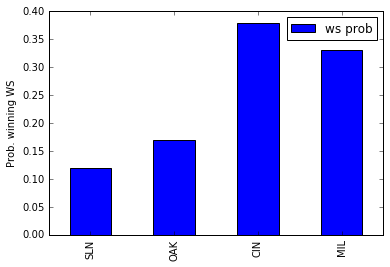

In [12]:
from collections import Counter
ws = pd.DataFrame.from_dict(Counter(winners),orient='index')/n_draws
ws.columns = ["ws prob"]
ax = ws.plot(kind='bar')
ax.set_ylabel('Prob. winning WS')

## Feature 2 - various W/L statistics about the regular season
Maybe a team makes the playoffs, but how are the wins distributed in their season:
* How did they do in the last X games of the season (half of the playoffs is about momentum).
* Maybe they are very streaky, e.g. 15 game winning streak followed by a 15 game losing streak.

In [10]:
def calc_win_stats(year,n_final_games):
    GL = get_gamelog(year)
    Team = GL["Team Home"].unique().tolist()
    EOS_Wins = np.zeros(len(Team))  #end of season wins
    game_no = 162 - n_final_games
    
    WL_dict = {}
    for t in Team:
        WL_dict[t] = []
        
    #Extract data
    for row in GL.itertuples():
        WL_dict[row[8]].append("W")
        WL_dict[row[9]].append("L")
        
        if (row[5] >= game_no) | (row[8] >= game_no):
            if (row[8] == row[2]) & (row[3] >=game_no):
                EOS_Wins[Team.index(row[8])] += 1
            elif (row[8] == row[4]) & (row[5] >=game_no):
                EOS_Wins[Team.index(row[8])] += 1
                
    #post-processing
    WL = ["W","L"]
    for t in Team:
        while len(WL_dict[t]) < 162:  #I guess there are a few missing values?
            WL_dict[t].insert(0,WL[np.random.randint(0,2)])
    
    fc = ["team","eos_wins"]
    return pd.DataFrame(zip(Team,EOS_Wins), columns=fc, index=Team), pd.DataFrame.from_dict(WL_dict, orient="index")

In [11]:
n_final_games = 10  #10 seems like a good value
final_wins, WLseq = calc_win_stats(2015,n_final_games)

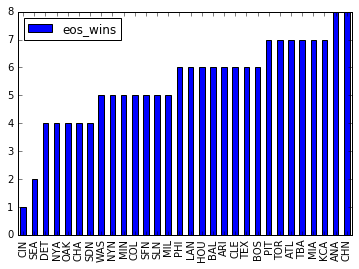

In [12]:
final_wins.sort_values("eos_wins").plot(kind='bar')

Now extract the win/loss streaks for each team. 

In [13]:
def get_WLstreaks(WL):
    Win_range = 15
    streak_dist = {}
    for team, WLrow in WL.iterrows():
        dist = np.empty(0)     #Each is a bin from -win_range to +win_range, excl. 0 
        WL_prev = WLrow[0]
        streak = 0
        for val in WLrow:
            if val == WL_prev:
                streak += 1
            else:
                index = -1 if WL_prev == "L" else 1
                dist = np.append(dist, streak*index)
                WL_prev = val
                streak = 1
        index = -1 if WL_prev == "L" else 1
        dist = np.append(dist, streak*index)
        streak_dist[team] = dist
    return streak_dist

In [14]:
streaks = get_WLstreaks(WLseq)

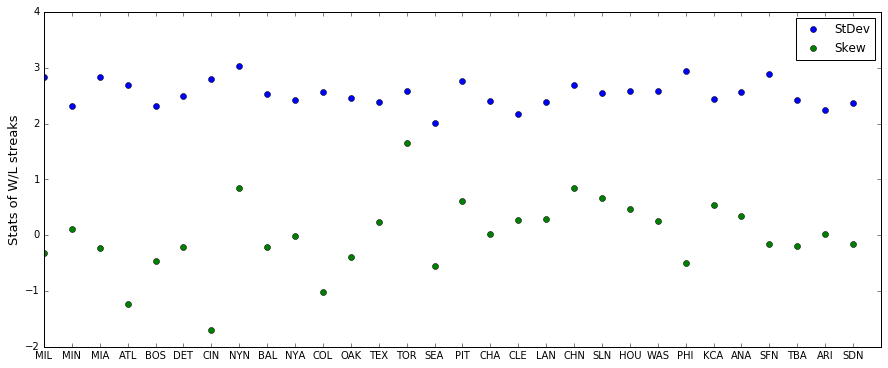

In [38]:
import scipy.stats as ss
std = []
skew = []
teams = streaks.keys()
plt.figure(figsize=(15,6))
for keys, values in streaks.iteritems():
    std.append(np.std(values))
    skew.append(ss.skew(values))
    
plt.plot(std,'o',label="StDev")
plt.plot(skew,"o",label="Skew")
plt.ylabel("Stats of W/L streaks", fontsize=13)
plt.legend(loc="upper right",numpoints=1)
plt.xticks(range(len(teams)),teams);

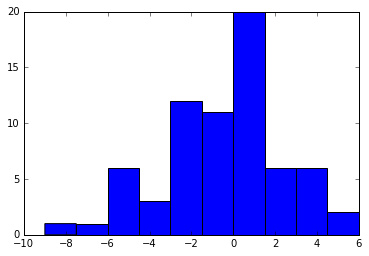

In [18]:
output,isall,junk = plt.hist(streaks["PHI"])

## Finally, some Machine Learning!
Now that we've spent quite some time creating the features we want to use, it's time to input these features and see how our algorithm performs!

### To do:
* The above code needs to be generalized to all years.
* 1994 - 1997 needs to have the bracket fixed (1994 no playoffs). For now, just exclude that data maybe.
* Also, you need to decide whether you're asking "Who is going to win the WS?", or "Who is likely to go deep in the playoffs?". I think the latter will yield better results. Basically have either separate columns (for whether or not the team made it to each round) or a single column with increasing number for each round they made it to. 

In [66]:
#load data of interest
year_cutoff = 1969

team = pd.read_csv("csv/team.csv")
team = team[(team["lg_win"]=="Y")|(team["wc_win"]=="Y")] #only want playoff teams
team = team[team["year"]>=year_cutoff]                   #1969 = since division series was made
team = team[(team["year"]>1997)|((team["year"]<1994))]   #dont want to deal with these years for now...
del_columns = ["div_id","name","team_id_lahman45","franchise_id","team_id_retro","team_id_br","ppf","bpf",
               "park","attendance"]
team.drop(del_columns, axis=1, inplace=True)
team.head()

,year,league_id,team_id,rank,g,ghome,w,l,div_win,wc_win,...,sho,sv,ipouts,ha,hra,bba,soa,e,dp,fp
1518,1969,AL,BAL,1,162,81.0,109,53,Y,NaN,...,20,36,4419,1194,117,498,897,101,145.0,0.98
1532,1969,NL,NYN,1,162,82.0,100,62,Y,NaN,...,28,35,4404,1217,119,517,1012,122,146.0,0.98
1542,1970,AL,BAL,1,162,81.0,108,54,Y,NaN,...,12,31,4434,1317,139,469,941,117,148.0,0.98
1547,1970,NL,CIN,1,162,81.0,102,60,Y,NaN,...,15,60,4332,1370,118,592,843,151,173.0,0.97
1566,1971,AL,BAL,1,158,77.0,101,57,Y,NaN,...,15,22,4245,1257,125,416,793,112,148.0,0.98


In [67]:
team.columns

Index([u'year', u'league_id', u'team_id', u'rank', u'g', u'ghome', u'w', u'l',
       u'div_win', u'wc_win', u'lg_win', u'ws_win', u'r', u'ab', u'h',
       u'double', u'triple', u'hr', u'bb', u'so', u'sb', u'cs', u'hbp', u'sf',
       u'ra', u'er', u'era', u'cg', u'sho', u'sv', u'ipouts', u'ha', u'hra',
       u'bba', u'soa', u'e', u'dp', u'fp'],
      dtype='object')

What you have to do now is do the above analysis for each year, grabbing the relevant teams to calculate the important stats.

# Extra

In [118]:
def get_WLstreaks(WL):
    Win_range = 15
    streak_dist = {}
    for team, WLrow in WL.iterrows():
        dist = np.zeros(2*Win_range+1)     #Each is a bin from -win_range to +win_range, excl. 0 
        WL_prev = WLrow[0]
        streak = 0
        for val in WLrow:
            if val == WL_prev:
                streak += 1
            else:
                index = -1 if WL_prev == "L" else 1
                if streak > Win_range:
                    dist[index*Win_range] += 1
                else:
                    dist[Win_range + streak*index] += 1
                WL_prev = val
                streak = 1
        index = -1 if WL_prev == "L" else 1
        if streak > Win_range:
            dist[index*Win_range] += 1
        else:
            dist[Win_range+streak*index] += 1
        streak_dist[team] = dist
    return np.arange(-Win_range,Win_range+1), streak_dist

In [ ]:
colnames=["Date","No.Gm in Series","Day","Team Away","Lg Away","Gm No. Away","Team Home","Lg Home","Gm No. Home",
          "Team Away Score","Team Home Score","No. outs","Day/Night","Completed","Forfeit","Protest","ParkID",
          "Attendance","Gm. Length","Team Away Ln. Sco.","Team Home Ln. Sco." ]
GL = pd.read_csv("retrosheet_GL/GL2015.TXT",usecols=range(len(colnames)),names=colnames)

In [ ]:
#save copy
def get_bracket(data,year,K_elo):  #1994 no WS, 1995-1997 is really weird seeding. Gonna be super annoying...
    Team, Elo, wins = zip(*data)
    teams = pd.read_csv("csv/team.csv")
    teams = teams.loc[(teams["year"]==year)] 
    
    AL = teams.loc[(teams["league_id"]=="AL")&(teams["rank"]==1)].sort_values("w")
    team_name = AL.loc[:,"team_id"].values.tolist()
    team_div = AL.loc[:,"div_id"].values.tolist()
    team_elo = []
    for t in team_name:
        t_id = Team.index(t)
        team_elo.append(Elo[t_id])
    if year >= 1994:
        WCAL = teams.loc[(teams["rank"]>1)&(teams["league_id"]=="AL")].sort_values("w",ascending=False)
        if year >= 2012:
            WCALteams = WCAL.loc[:,"team_id"].values[0:2]
            t1 = Team.index(WCALteams[0])
            t2 = Team.index(WCALteams[1])
            winner_wc_al, elo_wc_al = get_winner(Team[t1],Elo[t1],Team[t2],Elo[t2],"ALWC",K_elo)
            team_name.append(winner_wc_al)
            team_elo.append(elo_wc_al)
        else:
            if WCAL.loc[:,"div_id"].values[0] == team_div[-1]: #stupid 1998-2011 WC rules
                team_name[-2], team_name[-1] = team_name[-1], team_name[-2]
                team_elo[-2], team_elo[-1] = team_elo[-1], team_elo[-2]
            t1 = Team.index(WCAL.loc[:,"team_id"].values[0])
            team_name.append(Team[t1])
            team_elo.append(Elo[t1])

    NL = teams.loc[(teams["league_id"]=="NL")&(teams["rank"]==1)].sort_values("w")
    dummy = NL.loc[:,"team_id"].values.tolist()
    team_div = NL.loc[:,"div_id"].values.tolist()
    for t in dummy:
        t_id = Team.index(t)
        team_name.append(t)
        team_elo.append(Elo[t_id])
    if year >= 1994:
        WCNL = teams.loc[(teams["rank"]>1)&(teams["league_id"]=="NL")].sort_values("w",ascending=False)
        if year >= 2012:
            WCNLteams = WCNL.loc[:,"team_id"].values[0:2]
            t1 = Team.index(WCNLteams[0])
            t2 = Team.index(WCNLteams[1])
            winner_wc_nl, elo_wc_nl = get_winner(Team[t1],Elo[t1],Team[t2],Elo[t2],"NLWC",K_elo)
            team_name.append(winner_wc_nl)
            team_elo.append(elo_wc_nl)
        else:
            if WCNL.loc[:,"div_id"].values[0] == team_div[-1]: #stupid 1998-2011 WC rules
                team_name[-2], team_name[-1] = team_name[-1], team_name[-2]
                team_elo[-2], team_elo[-1] = team_elo[-1], team_elo[-2]
            t1 = Team.index(WCNL.loc[:,"team_id"].values[0])
            team_name.append(Team[t1])
            team_elo.append(Elo[t1])
    return team_name, team_elo

In [ ]:
Games = GL.loc[:,["Date","Team Away","Team Away Score","Team Home","Team Home Score","Winning Team","Losing Team"]]
Games.head()

In [ ]:
def MC(array,year,n_throws):
    postseason = pd.read_csv("csv/postseason.csv")
    bracket = postseason.loc[postseason["year"]==year]
    rounds = ["ALWC","NLWC","ALDS1","ALDS2","NLDS1","NLDS2","ALCS","NLCS","WS"]
    K_elo = 40
    Team, Elo, wins = zip(*array)
    #for r in rounds:
    r = "WS"
    team1 = Team.index(bracket.loc[bracket["round"]=="ALWC","team_id_winner"].values[0])
    team2 = Team.index(bracket.loc[bracket["round"]=="ALWC","team_id_loser"].values[0])
    return get_winner(Team[team1],Elo[team1],Team[team2],Elo[team2],r,K_elo)

In [ ]:
def simulate_DS(playoff_round,bracket,Team,Elos,K_elo):
    if playoff_round == "ALDS1": #first get wildcard winner
        wc1 = Team.index(bracket.loc[bracket["round"]=="ALWC","team_id_winner"].values[0])
        wc2 = Team.index(bracket.loc[bracket["round"]=="ALWC","team_id_loser"].values[0])
        team_won,elo_won = get_winner(Team[wc1],Elo[wc1],Team[wc2],Elo[wc2],"ALWC",K_elo)
        index = Team.index(team_won)
        Elos[index] = elo_won  #update elo of winning team
        team2 = bracket.loc[bracket["round"]=="ALDS1","team_id_winner"].values[0]
        if Team[index] == team2:
            team2 = bracket.loc[bracket["round"]=="ALDS1","team_id_loser"].values[0]
    elif playoff_round == "NLDS1":
        wc1 = Team.index(bracket.loc[bracket["round"]=="NLWC","team_id_winner"].values[0])
        wc2 = Team.index(bracket.loc[bracket["round"]=="NLWC","team_id_loser"].values[0])
        team_won,elo_won = get_winner(Team[wc1],Elo[wc1],Team[wc2],Elo[wc2],"NLWC",K_elo)
        index = Team.index(team_won)
        Elos[index] = elo_won  #update elo of winning team
        
    team2 = bracket.loc[bracket["round"]=="NLDS1","team_id_winner"].values[0]
    if Team[index] == team2:
        team2 = bracket.loc[bracket["round"]=="NLDS1","team_id_loser"].values[0]
    t1 = Team.index(index)
    t2 = Team.index()
    return get_winner(Team[t1],Elo[t1],Team[t2],Elo[t2],playoff_round,K_elo)

def simulate_WS(winners,series,index,K_elo):
    team_1, elo_1 = winners[2*index]
    team_2, elo_2 = winners[2*index + 1]
    return get_winner(team_1,elo_1,team_2,elo_2,series,K_elo)

In [ ]:
Team, Elo, wins = zip(*array)

teams = pd.read_csv("csv/team.csv")
teams = teams.loc[(teams["year"]==year)]
K_elo = 20

AL = teams.loc[(teams["league_id"]=="AL")&(teams["rank"]==1)].sort_values("w")
team_name = AL.loc[:,"team_id"].values.tolist()
team_elo = []
for t in team_name:
    t_id = Team.index(t)
    team_elo.append(Elo[t_id])

WCAL = teams.loc[(teams["rank"]>1)&(teams["league_id"]=="AL")].sort_values("w",ascending=False)
WCALteams = WCAL.loc[:,"team_id"].values[0:2]
winner_wc_al, elo_wc_al = get_winner(WCALteams[0],WCALteams[1],Team,Elo,"ALWC",K_elo)
team_name.append(winner_wc_al)
team_elo.append(elo_wc_al)

NL = teams.loc[(teams["league_id"]=="NL")&(teams["rank"]==1)].sort_values("w")
dummy = NL.loc[:,"team_id"].values.tolist()
for t in dummy:
    t_id = Team.index(t)
    team_name.append(t)
    team_elo.append(Elo[t_id])

WCNL = teams.loc[(teams["rank"]>1)&(teams["league_id"]=="NL")].sort_values("w",ascending=False)
WCNLteams = WCNL.loc[:,"team_id"].values[0:2]
winner_wc_nl, elo_wc_nl = get_winner(WCNLteams[0],WCNLteams[1],Team,Elo,"NLWC",K_elo)
team_name.append(winner_wc_nl)
team_elo.append(elo_wc_nl)
team_name, team_elo